In [1]:
# Import necessary libraries
import numpy as np
import ast
import psycopg2
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
import plotly.express as px
import plotly.io as pio
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
pio.renderers.default = 'notebook'

In [2]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname="manga_db",
    user="user_master",
    password="PassMaster97",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

In [3]:
# Fetch data from the database
df = pd.read_sql("""
    SELECT DISTINCT ON (mb.original_title)
    mb.id,
    mb.title,
    mb.is_editorial,
    mb.original_title,
    me.embeddings_synopsis_tags,
    me.embeddings_features
    FROM mangas_base mb
    JOIN mangas_embeddings me ON mb.id = me.manga_id
    WHERE me.embeddings_synopsis_tags IS NOT NULL
    AND me.embeddings_features IS NOT NULL
    ORDER BY mb.original_title, mb.is_editorial DESC;
""", conn)

/var/folders/1f/nl9h7sjs4617dm270zv75gq80000gn/T/ipykernel_10601/3596392785.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [6]:
# Function to safely evaluate string representations of lists
def safe_eval(val):
    if pd.isna(val) or val is None:
        return np.array([]) 
    try:
        return np.array(ast.literal_eval(val))
    except Exception as e:
        print(f"❌ Error con valor: {val}\n{e}")
        return np.array([])

# Apply the safe_eval function to the embeddings columns
df["emb_syn_tags_np"] = df["embeddings_synopsis_tags"].apply(safe_eval)
df["emb_features_np"] = df["embeddings_features"].apply(safe_eval)

# Filter the DataFrame to only include rows with non-empty embeddings
df_filtered = df[
    (df["emb_syn_tags_np"].apply(lambda x: x.size > 0)) &
    (df["emb_features_np"].apply(lambda x: x.size > 0))
]


# Convert the embeddings to numpy arrays
X_tags = np.vstack(df_filtered["emb_syn_tags_np"].values)
X_feat = np.vstack(df_filtered["emb_features_np"].values)

In [ ]:
def compute_gap_statistic(X, k_max=15, n_refs=10):
    from sklearn.metrics import pairwise_distances

    gaps = []
    deviations = []
    ref_disps = []

    # Bounding box of the dataset
    shape = X.shape
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)

    for k in range(2, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        km.fit(X)
        disp = km.inertia_

        ref_disps_k = []
        for _ in range(n_refs):
            # Uniformly sampled random reference set
            X_ref = np.random.uniform(mins, maxs, size=shape)
            km_ref = KMeans(n_clusters=k, random_state=42, n_init="auto")
            km_ref.fit(X_ref)
            ref_disps_k.append(km_ref.inertia_)

        ref_log_disp = np.log(ref_disps_k)
        gap = np.mean(ref_log_disp) - np.log(disp)
        sd = np.std(ref_log_disp) * np.sqrt(1 + 1 / n_refs)

        gaps.append(gap)
        deviations.append(sd)

    return gaps, deviations

In [ ]:
def evaluate_clusters(X, name=""):
    inertia = []
    silhouette = []

    k_values = range(2, 15)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(X, labels))

    # Gap Statistic
    gaps, deviations = compute_gap_statistic(X, k_max=max(k_values))

    # Plot all three
    plt.figure(figsize=(18, 5))

    # Elbow
    plt.subplot(1, 3, 1)
    plt.plot(k_values, inertia, marker='o')
    plt.title(f"Elbow Method ({name})")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")

    # Silhouette
    plt.subplot(1, 3, 2)
    plt.plot(k_values, silhouette, marker='o', color='green')
    plt.title(f"Silhouette Score ({name})")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")

    # Gap Statistic
    plt.subplot(1, 3, 3)
    plt.plot(k_values, gaps, marker='o', color='purple')
    plt.errorbar(k_values, gaps, yerr=deviations, fmt='o', color='purple', capsize=5)
    plt.title(f"Gap Statistic ({name})")
    plt.xlabel("Number of clusters")
    plt.ylabel("Gap Value")

    plt.tight_layout()
    plt.show()


📘 Evaluating embeddings Synopsis + Tags:


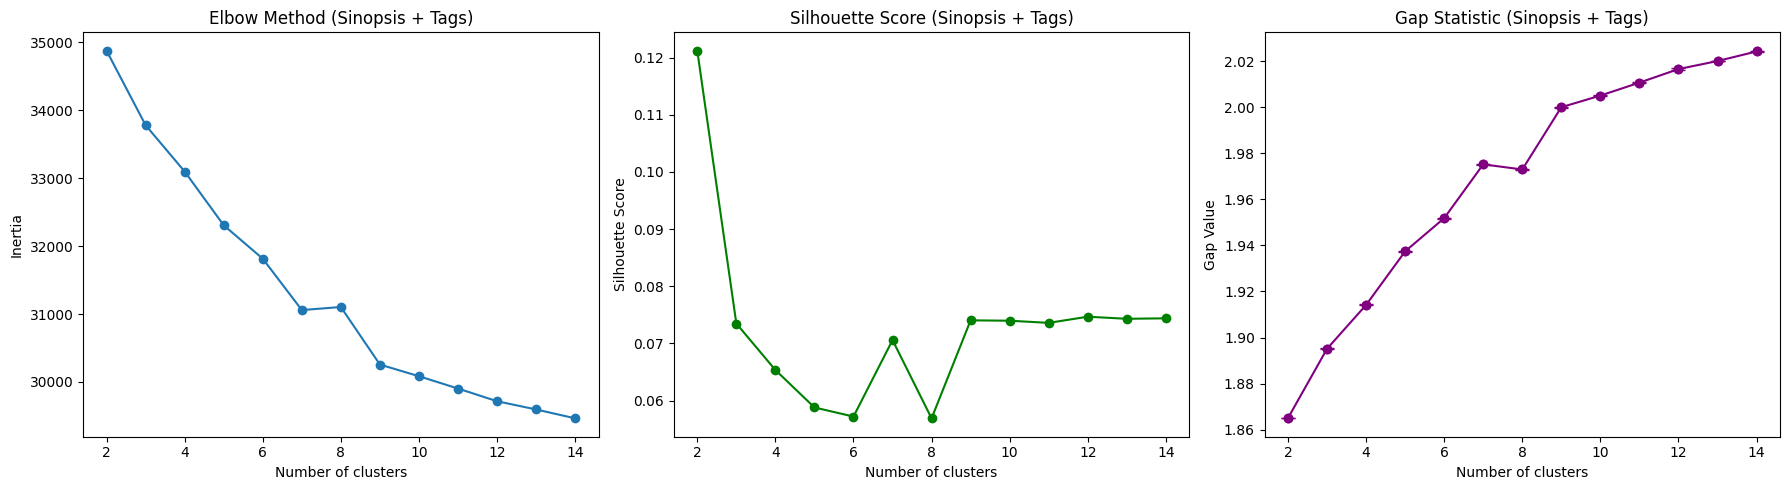


📗 Evaluating embeddings Features:


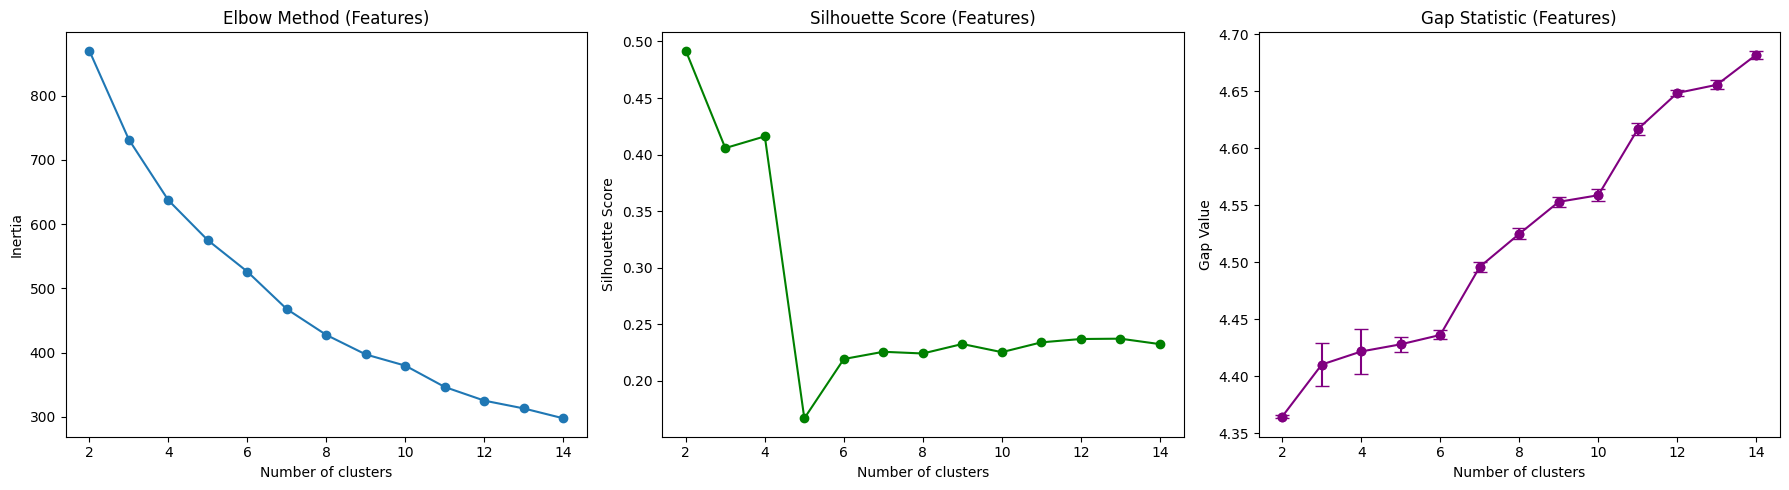

In [ ]:
print("\n📘 Evaluating embeddings Synopsis + Tags:")
evaluate_clusters(X_tags, name="Sinopsis + Tags")

print("\n📗 Evaluating embeddings Features:")
evaluate_clusters(X_feat, name="Features")

In [7]:
# Choose the number of clusters based on the evaluation
n_clusters_synopsis_tags = 7
n_clusters_features = 4

# Fit KMeans with the chosen number of clusters
kmeans_tags = KMeans(n_clusters=n_clusters_synopsis_tags, random_state=42).fit(X_tags)
kmeans_feat = KMeans(n_clusters=n_clusters_features, random_state=42).fit(X_feat)

df_filtered["cluster_tags"] = kmeans_tags.labels_
df_filtered["cluster_features"] = kmeans_feat.labels_

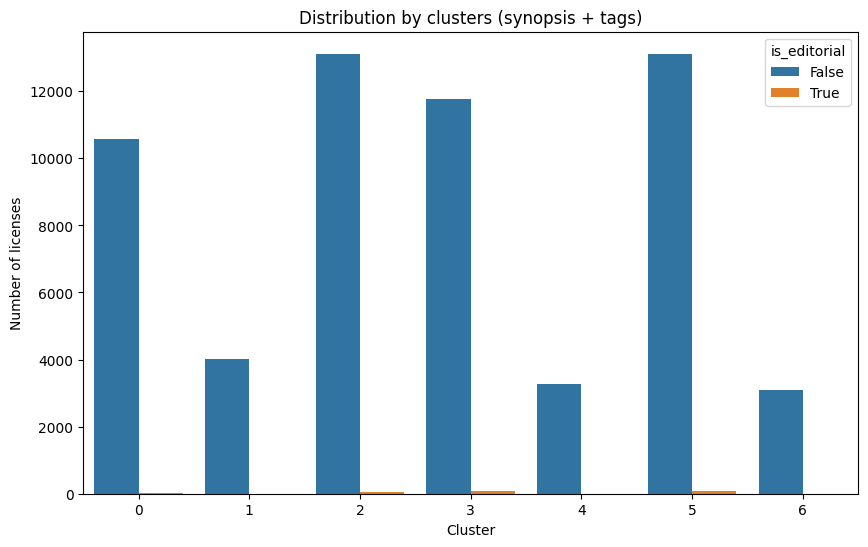

In [9]:
# Agrupate by cluster and is_editorial
cluster_counts = df_filtered.groupby(["cluster_tags", "is_editorial"]).size().reset_index(name="count")

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_counts, x="cluster_tags", y="count", hue="is_editorial")
plt.title("Distribution by clusters (synopsis + tags)")
plt.xlabel("Cluster")
plt.ylabel("Number of licenses")
plt.show()

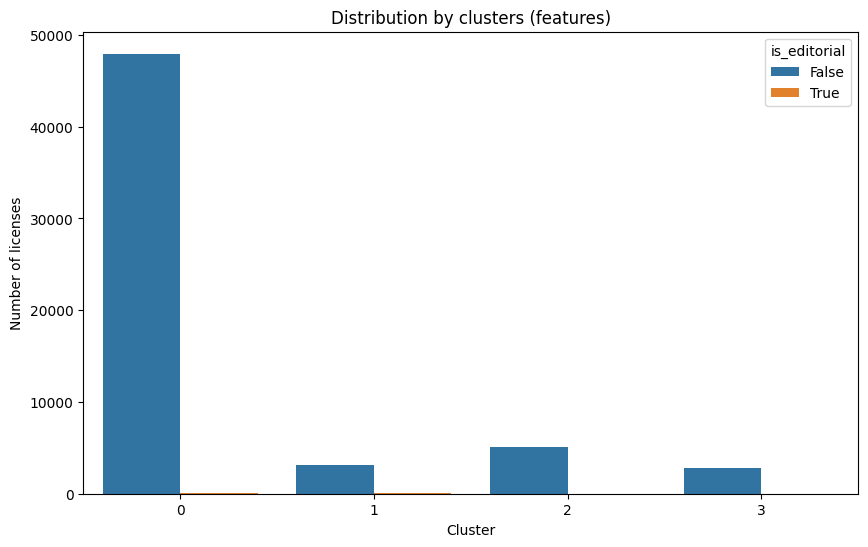

In [10]:
# Agrupate
cluster_counts = df_filtered.groupby(["cluster_features", "is_editorial"]).size().reset_index(name="count")

# Plot the distribution of clusters
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_counts, x="cluster_features", y="count", hue="is_editorial")
plt.title("Distribution by clusters (features)")
plt.xlabel("Cluster")
plt.ylabel("Number of licenses")
plt.show()

In [49]:
def obtener_similares_por_kmeans(df_filtered, emb_column, cluster_column, top_n=10):
    df_editorial = df_filtered[df_filtered["is_editorial"] == True]
    df_otros = df_filtered[df_filtered["is_editorial"] == False]
    
    tabla_similares = []

    for _, row in df_editorial.iterrows():
        obra_id = row["id"]
        obra_title = row["title"]
        obra_cluster = row[cluster_column]
        obra_vector = row[emb_column]

        # Solo consideramos obras no editoriales del mismo cluster
        df_cluster = df_otros[df_otros[cluster_column] == obra_cluster].copy()
        if df_cluster.empty:
            continue

        X_cluster = np.vstack(df_cluster[emb_column].values)

        # Calculamos distancia euclidiana
        distancias = euclidean_distances([obra_vector], X_cluster)[0]

        # Seleccionar los top_n más cercanos
        top_idx = distancias.argsort()[:top_n]
        similares = df_cluster.iloc[top_idx]

        fila = {
            "Obra Editorial": obra_title,
            "ID Editorial": obra_id,
            "Cluster": obra_cluster
        }

        for j, (_, sim_row) in enumerate(similares.iterrows(), 1):
            fila[f"Similar {j}"] = sim_row["title"]
            fila[f"ID {j}"] = sim_row["id"]

        tabla_similares.append(fila)

    return pd.DataFrame(tabla_similares)

In [52]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get similar works based on features
similares_features_kmeans = obtener_similares_por_kmeans(
    df_filtered,
    emb_column="emb_features_np",
    cluster_column="cluster_features",
    top_n=10
)

In [53]:
similares_features_kmeans

,Obra Editorial,ID Editorial,Cluster,Similar 1,ID 1,Similar 2,ID 2,Similar 3,ID 3,Similar 4,ID 4,Similar 5,ID 5,Similar 6,ID 6,Similar 7,ID 7,Similar 8,ID 8,Similar 9,ID 9,Similar 10,ID 10
0,#DRCL – Midnight Children,114084,0,Dramatic-age Saranghaejwo,169439,Bamman Jal Sajuneun Isanghan Isanim,169459,Danjjagui Gyeonggye,169665,Marie Alex,170034,Ireumeul Matchumyeo,170014,Jujutsu Kaisen Bangai-hen,162303,Kuroiwa Medaka ni Watashi no Kawaii ga Tsuujinai,160303,"Tokyo Umare, Tokyo Sodachi.",138895,Wash me Hug me!,150646,Kanojo to Boku no Endroll,162304
1,Love at Fourteen,114152,2,Danchigai,133588,GUNNM: Kasei Senki,133612,Persona 4,140458,Persona 3,130974,Ani no Yome to Kurashiteimasu.,134786,Arakawa Under the Bridge,131518,Futaribeya,141591,Chi's Sweet Home,130904,Omairi Desu yo,115051,Shutohel,131363
2,7000 millones de agujas,114045,0,Itadakimasu,126213,Watashi to Fukigen na Panya-san,147073,Ero Ero Sos!,167934,Wandal Wandering!,155968,Pride (Knock),168065,Gyon-Woo & Jik-Nyu,167661,Otenba Tenshi,152271,TO-mA,139233,Wizards Nation,131836,Dorobou Neko ni wa Nusumenai,122864
3,"Hotel, Historias cortas de Boichi",114115,3,Shin Yami no Koe: Kaidan,127764,Kimi ni Shika Kikoenai,155722,Junketsu Drop,115014,Yeol-Ahobseumulhana,167437,Beast Master,143470,Samurai Champloo,155075,Black Paradox,131955,Deep Love: Ayu no Monogatari,143150,Negative-kun to Positive-kun,114949,Magi no Okurimono,133544
4,CANIS -Dear Hatter-,114233,3,Canis: Dear Hatter,120725,Paradise View,118758,3 Ban Sen no Campanella,120343,Yukidoke no Koi,119436,Dajeonghan Gyeoul,167575,Steins;Gate Onshuu no Brownian Motion,132652,Gohan no Otomo,135685,Stigmata: Seikon Sousa,134434,Yamada to Shounen,119966,Shinobeba Koi,118575
5,CANIS -Dear Mr.Rain- (Nueva Edición),114236,3,Canis: Dear Mr. Rain,115127,O.B.,115021,Hana no Miyako de,118083,Shin Getter Robo,155562,Jackass!,118571,Kani ni Sasowarete,127360,Kazoku ni Narouyo,120233,Gekijouban Mahou Shoujo Madoka★Magica: Shinpen...,165460,Kurayami Dance,135925,Akai Ito no Shikkou Yuuyo,120270
6,CANIS -The Speaker-,114237,2,Canis: The Speaker,120726,Anti Romance,119216,Sword Art Online: Phantom Bullet,133398,Castle Mango,114842,Hate Mate,167903,KILLING ME / KILLING YOU,136960,Fate/Grand Order From Lostbelt,159275,Otonari Complex,150100,Hitoribocchi wa Samishikute,145356,Talk to Me,167737
7,Hideout,114113,0,Yoake no Yami ni Nemuru Koi,118767,Ai wa Ichiya ni Shite,126447,Change H purple,137928,Akapoli,139934,Daikanojo,139421,Change H white,137929,Yume Yume Utsutsu,164541,Mitsurugi Haruka Kiki Ippatsu!,140783,Oshioki Ouji,147753,Boku ga Arukeba♂Osowareru,122710
8,MADK,114261,3,Tteugeopge Anajwo,168536,Bungou Stray Dogs: Dead Apple,136864,Boku no Omawari-san,119532,Red Candy,168626,King's Maker: Triple Crown,168708,Dear Door,168378,Watashi wa Kabe ni Naritai,151969,Bring the Love,168878,Dungeon Sok Sajeong,168914,Ouji-sama Nante Iranai,164648
9,La música de Marie,114139,3,J no Subete,116963,Higurashi no Naku Koro ni: Tatarigoroshi-hen,155189,GOGO Monster,135752,Glass no Kamen,143184,Higurashi no Naku Koro ni: Watanagashi-hen,161669,Hotarubi no Mori e,143406,not simple,124240,Kagen no Tsuki,143152,Kono Sekai no Katasumi ni,131338,pink,126861


In [54]:
# Get similar works based on synopsis + tags
similares_tags_kmeans = obtener_similares_por_kmeans(
    df_filtered,
    emb_column="emb_syn_tags_np",
    cluster_column="cluster_tags",
    top_n=10
)

In [55]:
similares_tags_kmeans

,Obra Editorial,ID Editorial,Cluster,Similar 1,ID 1,Similar 2,ID 2,Similar 3,ID 3,Similar 4,ID 4,Similar 5,ID 5,Similar 6,ID 6,Similar 7,ID 7,Similar 8,ID 8,Similar 9,ID 9,Similar 10,ID 10
0,#DRCL – Midnight Children,114084,0,Yasha,139796,DARK MOON: Darui Jedan,171172,Deathmon,140045,Burning Hell: Kami no Kuni,131713,Ingoshima,135522,QUO VADIS,136245,Kill your HONEY♥,173092,BLACK LAGOON: Soujiya Sawyer Kaitai! Gore Gore...,137978,Vampire Hunter D,140547,Jinrou Game,133420
1,Love at Fourteen,114152,2,Love Train,175168,Gomen ne Hatsukoi,152513,Itoi-kun to Hiyama-kun no Koi,125285,Senpai wa Otokonoko,166764,Dounika Naru Hibi,164207,Kiss Shiyou Te wo Tsunagou,116654,Mimi ni Nokoru Kimi no Koe wa,114702,Mikako-san,134875,Ryou Omoi no Kakuritsu Ron,114444,Boku wa Sakana.,114730
2,7000 millones de agujas,114045,0,Dead Dead Demon's Dededededestruction,166422,Jiya,131844,Uchuu Ryuugakusei Moru,139397,Navigatoria,162740,"Kouchuugun Shikan, Boukensha ni Naru",137400,Cyber Planet 1999: HYPER☆Rune,142957,Abunai Oka no Ie,145243,DARKNESS HEELS: Lili,141903,Devil 17 - Hokago no Kusenshi,155978,Loan Wolf,139734
3,"Hotel, Historias cortas de Boichi",114115,6,Chikyuu Hyoukai Jiki,135363,Sayonara Watashitachi,145776,"49-Sai, Hitou Hitoritabi",129863,2015 Uju Teukjib Danpyeon,167689,Gigi Goegoe,168348,Byeollara Gongjunim,173287,2001-ya Monogatari,130801,Watashi ga Mita Mirai,152169,Eoljjangsidae,174184,Melancholia,135551
4,CANIS -Dear Hatter-,114233,2,Canis: Dear Mr. Rain,115127,Okyakusama ni Koishite mo Ii desu ka?,125441,Shouboushi-san to BL Kissa,124906,FLAT LAY,169938,Uragirimono no Love Song,124741,Goodbye Harlequin,119551,"Shinyuu no ""Dousei Shite"" ni ""Un"" te Iu Made",124964,Minato Shouji Coin Laundry,151814,Oni Joushi Gokudera-san wa Abakaretai.,122649,Sex Influencer,124200
5,CANIS -Dear Mr.Rain- (Nueva Edición),114236,6,Kiss wa Sousa no Ato de,125842,Iya tte Itte mo Kikanai de,125934,Zurui Kimi to no Tomodachi Gokko,125923,After Act,125922,Downer-kei Joushi wo Koi ni Otosu Houhou,125844,Hajimari wa One Night Regret,125211,Doujou Shita no ga Un no Tsuki,124992,"Iya yo Iya yo mo, Koi no Uchi",125839,Oaiko.,125840,"Hoenai Inu wa, Neko wo Naderu",125092
6,CANIS -The Speaker-,114237,2,Ore no Kimochi ga Wakaru ka,119786,Ieneko Nora wa Oogataken ga Nigate,121430,Ookami no Ketsuzoku,117374,Yaneura no Neko to Nidome no Hatsukoi,125952,Hi Me KO l,116212,Kami-sama no Ude no Naka,115332,Yamada to Shounen,119966,2020,174891,Urisen Boy to Koisuru Onzoushi,121493,Canis: Dear Mr. Rain,115127
7,Hideout,114113,4,HIDEOUT,132623,Inganmaljong,175895,Muneojin Yeoche,173867,Ppaesneun Namja,175194,Eorin Gajeongbu,173661,Kusakabe-san,136407,Yawang Seonggwinam,171496,Nuna Gildeurigi,172350,Suicide Girl,136996,Mina,172875
8,MADK,114261,0,Devilman,125281,Mawangnimui Ijungsaenghwal,169819,Devilman Tai Yami no Teiou: DEVILMAN vs HADES,134212,Yuujin ga Yuusha,117949,Rakuin no Kemonobito,139603,Kimetsu no Yaiba,157770,Gekka Kajin LUMEN LUNAE,114369,Dororo,158913,Maou no Musume wa Yasashi Sugiru!!,141815,Tsui no Taimashi: Ender Geister,159728
9,La música de Marie,114139,4,"Youkihi, Kirara",152892,36°C Rebellion,167170,Onryou Juusanya,140747,Honzuki no Gekokujou: Shisho ni Naru Tame ni w...,130652,Toraware no Himegimi,140742,Yougisha A no Hanayome,152480,Juin no Onna Kenshi,150673,Nekomonogatari: Shiro,166586,Yoru no Hana,148845,Otome Kaiju Caramelise,138439


In [187]:
def distancia_a_centroide_kmeans(obra1_id, obra2_id, df, emb_column, kmeans_model):
    # Obtener vectores de embeddings
    vec1 = df.loc[df["id"] == obra1_id, emb_column].values
    vec2 = df.loc[df["id"] == obra2_id, emb_column].values
    
    if len(vec1) == 0 or len(vec2) == 0:
        raise ValueError("Alguno de los IDs no se encuentra en el DataFrame.")
    
    vec1 = vec1[0]
    vec2 = vec2[0]

    # Obtener centroides asignados
    cluster1 = kmeans_model.predict([vec1])[0]
    cluster2 = kmeans_model.predict([vec2])[0]

    centroide1 = kmeans_model.cluster_centers_[cluster1]
    centroide2 = kmeans_model.cluster_centers_[cluster2]

    # Distancias
    dist1 = euclidean_distances([vec1], [centroide1])[0][0]
    dist2 = euclidean_distances([vec2], [centroide1])[0][0]
    dist_entre_centroides = euclidean_distances([centroide1], [centroide2])[0][0]

    return {
        "cluster_obra1": cluster1,
        "cluster_obra2": cluster2,
        "dist_obra1_centroide": dist1,
        "dist_obra2_centroide": dist2,
        "dist_entre_centroides": dist_entre_centroides,
        "sum_distancias": dist1 + dist2 + dist_entre_centroides
    }

Eso se interpreta como una ruta desde la obra A hasta su centroide → luego al centroide de B → y por último a B.
Es una especie de distancia proyectada entre dos puntos pasando por sus centroides.

🧠 ¿Tiene sentido?
Sí, si estás interpretando los clusters como "zonas" o "conceptos", y quieres saber cuán lejos conceptual y espacialmente están esas dos obras.

Este método penaliza que estén en clusters diferentes y también cuán alejadas están de su "centro conceptual".

In [204]:
distancia_a_centroide_kmeans(114114, 132216, df_filtered, "emb_syn_tags_np", kmeans_tags)

{'cluster_obra1': np.int32(2),
 'cluster_obra2': np.int32(0),
 'dist_obra1_centroide': np.float64(0.6804975327758304),
 'dist_obra2_centroide': np.float64(0.7067941312056754),
 'dist_entre_centroides': np.float64(0.3636719639925151),
 'sum_distancias': np.float64(1.7509636279740208)}

In [ ]:
# Group by cluster_tags and tipo
tabla_tags = df_filtered.groupby(["cluster_tags", "tipo"]).size().unstack(fill_value=0)

# Group by cluster_features and tipo
tabla_features = df_filtered.groupby(["cluster_features", "tipo"]).size().unstack(fill_value=0)

# show the tables
print("📘 Grouping by cluster_tags (sinopsis + tags):")
display(tabla_tags)

print("\n📗 Grouping by cluster_features:")
display(tabla_features  )

KeyError: 'tipo'

In [ ]:
# ------------------------------
# 1. PURITY OF CLUSTERS
# ------------------------------
def calcular_pureza(df, cluster_col):
    total_samples = len(df)
    pureza_total = 0

    for cluster_id, grupo in df.groupby(cluster_col):
        cuenta_tipos = grupo["tipo"].value_counts()
        maximo = cuenta_tipos.max()
        pureza_cluster = maximo / len(grupo)
        pureza_total += maximo

        print(f"Cluster {cluster_id} ({len(grupo)} works): purity = {pureza_cluster:.2f} | composition = {cuenta_tipos.to_dict()}")

    pureza_global = pureza_total / total_samples
    print(f"\n🔎 Global purity ({cluster_col}): {pureza_global:.2f}")
    return pureza_global

print("\n🔷 PURITY - cluster_tags")
pureza_tags = calcular_pureza(df_filtered, "cluster_tags")

print("\n🔶 PURITY - cluster_features")
pureza_features = calcular_pureza(df_filtered, "cluster_features")


# ------------------------------
# 2. CONTINGENCY MATRIX 
# ------------------------------
print("\n🧮 CONTINGENCY MATRIX (cluster_tags vs cluster_features)")
matriz_contingencia = pd.crosstab(df_filtered["cluster_tags"], df_filtered["cluster_features"])
display(matriz_contingencia)


🔷 PURITY - cluster_tags
Cluster 0 (6452 works): purity = 0.99 | composition = {'otros': 6397, 'similar': 44, 'editorial': 11}
Cluster 1 (1681 works): purity = 1.00 | composition = {'otros': 1681}
Cluster 2 (4031 works): purity = 1.00 | composition = {'otros': 4016, 'similar': 14, 'editorial': 1}
Cluster 3 (3904 works): purity = 1.00 | composition = {'otros': 3886, 'similar': 15, 'editorial': 3}
Cluster 4 (2371 works): purity = 0.99 | composition = {'otros': 2355, 'similar': 16}
Cluster 5 (7023 works): purity = 0.99 | composition = {'otros': 6985, 'similar': 25, 'editorial': 13}
Cluster 6 (2835 works): purity = 0.99 | composition = {'otros': 2814, 'similar': 20, 'editorial': 1}
Cluster 7 (6795 works): purity = 0.99 | composition = {'otros': 6760, 'similar': 27, 'editorial': 8}
Cluster 8 (3003 works): purity = 1.00 | composition = {'otros': 2995, 'similar': 8}
Cluster 9 (4608 works): purity = 1.00 | composition = {'otros': 4597, 'similar': 6, 'editorial': 5}
Cluster 10 (2300 works): pur

cluster_features,0,1,2,3,4
cluster_tags,,,,,
0,988,2920,1149,368,1027
1,217,1335,100,25,4
2,639,2491,599,150,152
3,404,1187,514,99,1700
4,466,1591,196,88,30
5,812,5526,386,62,237
6,672,1859,81,118,105
7,1157,4298,1015,167,158
8,555,2161,213,61,13


In [25]:
def obtener_distancia_normalizada_kmeans_cluster_individual(df, id_editorial, id_otra, emb_column, cluster_column):
    # Obtener las filas correspondientes
    row_ed = df[df["id"] == id_editorial]
    row_ot = df[df["id"] == id_otra]

    # Validaciones básicas
    if row_ed.empty or row_ot.empty:
        return "❌ Uno de los IDs no existe en el DataFrame."

    row_ed = row_ed.iloc[0]
    row_ot = row_ot.iloc[0]

    cluster_ed = row_ed[cluster_column]
    cluster_ot = row_ot[cluster_column]

    if cluster_ed != cluster_ot:
        return f"⚠️ Los mangas {id_editorial} y {id_otra} están en clusters diferentes: {cluster_ed} vs {cluster_ot}"

    # Obtener todas las obras del mismo cluster NO editoriales
    df_cluster = df[
        (df[cluster_column] == cluster_ed) &
        (df["is_editorial"] == False)
    ].copy()

    if df_cluster.empty:
        return f"⚠️ No hay obras no editoriales en el cluster {cluster_ed}"

    # Vector de la obra editorial
    vector_ed = row_ed[emb_column].reshape(1, -1)

    # Matriz de vectores del cluster
    X_cluster = np.vstack(df_cluster[emb_column].values)

    # Calcular distancias euclidianas
    distancias = euclidean_distances(vector_ed, X_cluster)[0]

    # Normalizar distancias a rango [0,1] donde 0 es la más cercana y 1 la más lejana
    if len(distancias) > 1:
        min_dist = distancias.min()
        max_dist = distancias.max()
        
        # Evitar división por cero si todas las distancias son iguales
        if max_dist == min_dist:
            distancias_normalizadas = np.zeros_like(distancias)
        else:
            distancias_normalizadas = (distancias - min_dist) / (max_dist - min_dist)
    else:
        # Si solo hay una distancia, asignar 0 (máxima similitud)
        distancias_normalizadas = np.array([0.0])

    # Calcular también similaridad (1 - distancia_normalizada)
    # Así 1 significa máxima similitud y 0 mínima similitud
    similaridad_normalizada = 1 - distancias_normalizadas

    # Obtener índice de la obra buscada dentro del cluster
    ids_cluster = df_cluster["id"].tolist()
    try:
        idx = ids_cluster.index(id_otra)
        posicion = np.argsort(distancias)[::1].tolist().index(idx) + 1  # Ordenar de menor a mayor distancia
        distancia_original = distancias[idx]
        distancia_normalizada = distancias_normalizadas[idx]
        similaridad = similaridad_normalizada[idx]
    except ValueError:
        return f"⚠️ La obra {id_otra} no se encuentra en el mismo cluster como no editorial."

    # Añadir también el z-score original para comparación
    mean_dist = distancias.mean()
    std_dist = distancias.std()
    z_score = (distancia_original - mean_dist) / std_dist if std_dist != 0 else 0

    # Resultado
    return {
        "id_editorial": id_editorial,
        "id_otro": id_otra,
        "cluster": cluster_ed,
        "distancia_original": distancia_original,
        "distancia_normalizada": distancia_normalizada,
        "similaridad": similaridad,
        "z_score": z_score,
        "posición_en_cluster": posicion,
        "total_obras_en_cluster": len(ids_cluster)
    }

In [178]:
resultado = obtener_distancia_normalizada_kmeans_cluster_individual(
    df_filtered,
    id_editorial=114114,
    id_otra=168606,
    emb_column="emb_features_np",
    cluster_column="cluster_features"
)

print(resultado)

{'id_editorial': 114114, 'id_otro': 168606, 'cluster': np.int32(3), 'distancia_original': np.float64(0.057894722701826), 'distancia_normalizada': np.float64(0.002276841443548126), 'similaridad': np.float64(0.9977231585564519), 'z_score': np.float64(-1.165752414101766), 'posición_en_cluster': 8, 'total_obras_en_cluster': 3142}
